In [1]:
import os
import gym
import numpy as np
import torch
from tqdm import tqdm
from CustomGymEnvs import MujocoGraphNormalWrapper, FetchReachGraphWrapper
from pathlib import Path
from Graph_SAC.sac import SAC
from utils import state_2_graphbatch, load_object
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style


In [2]:
env_name = 'HalfCheetah-v2'
# env_name = 'Walker2d-v2'
# env_name = 'Hopper-v2'
# env_name = 'FetchReach-v2'

In [3]:
exp_path = os.path.join(Path(os.getcwd()), 'Data', env_name, 'graph')
obj_path = os.path.join(exp_path, 'edge_relevance.pkl')
edge_relevance = load_object(obj_path)
if env_name == 'FetchReach-v2':
    edge_relevance = np.delete(edge_relevance, 7, axis=0)
    edge_relevance = np.delete(edge_relevance, 7, axis=0)


In [4]:
# Environment
if 'FetchReach' in env_name:
    env = FetchReachGraphWrapper(gym.make(env_name))
else:
    env = MujocoGraphNormalWrapper(env_name)

edge_list = env.robot_graph.edge_list
node_list = env.robot_graph.node_list

dict_values([[<Element 'joint' at 0x7f0cb7a6a770>, <Element 'joint' at 0x7f0cb7a6a7c0>, <Element 'joint' at 0x7f0cb7a6a810>], [<Element 'joint' at 0x7f0cb7a6ac20>], [<Element 'joint' at 0x7f0cb7a6af90>], [<Element 'joint' at 0x7f0cb7a74360>], [<Element 'joint' at 0x7f0cb7a74720>], [<Element 'joint' at 0x7f0cb7a74a90>], [<Element 'joint' at 0x7f0cb7a74db0>]])


In [5]:
def process_joint_name(joint_name):
    separated = joint_name.split(':')[1].split('_') if 'robot0' in joint_name else joint_name.split('_')
    final_key = ''
    for sk in separated:
        if len(sk) == 1:
            final_key += sk + '-'
        else:
            final_key += sk + ' '
    return final_key.strip()

joint_names = []
for joint_list in edge_list.values():
    if len(joint_list) > 0:
        joint_names.append(
            process_joint_name(joint_list[0].attrib['name'])
            if len(joint_list) == 1
            else '\n'.join([process_joint_name(j.attrib['name']) for j in joint_list])
        )


if env_name == 'FetchReach-v2':
    joint_names.remove('l-gripper finger joint')
    joint_names.remove('r-gripper finger joint')

joint_names = [j if 'joint' not in j else j.split('joint')[0].strip() for j in joint_names]

action_labels = [j for j in joint_names if 'root' not in j]


In [6]:
def plot_joint_action_heatmap(data, width, height):
    plt.rcParams.update({'font.size': 16})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'width_ratios': (30, 1)})
    sns.heatmap(data, ax=ax1, cbar=False, 
                cmap="cividis", 
                linewidth=1, 
                vmin=np.min(data), 
                vmax=np.max(data),
                annot=True,
                fmt='.2f')
    ax1.set_xticks(np.arange(len(joint_names)) + 0.5, labels=[j for j in joint_names], rotation=45)
    ax1.set_yticks(np.arange(len(action_labels)) + 0.5, labels=action_labels, rotation=45)
    ax1.set_title(f"Avg action-joint relevance score - {env_name}", fontsize=20, pad=40)
    ax1.set_ylabel("Actions (Torques applied to each joint)")
    ax1.set_xlabel(f"Joint name")

#     ax3 = ax1.twiny()
#     ax3.set_xlim([0, ax1.get_xlim()[1]])
#     ax3.set_xticks(ax1.get_xticks())
#     ax3.set_xticklabels(np.round(importance, 2))

    plt.colorbar(plt.cm.ScalarMappable(cmap="cividis", norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data))), cax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_ylabel('Avg relevance score across seeds')
    fig.tight_layout()
    fig.savefig(os.path.join(exp_path, 'LRP_result.jpg'), dpi=300)
    plt.show()

Since the scores for each action is different according to the probability, we normalize across actions.

In [7]:
avg_edge_rel = edge_relevance.mean(axis=4).mean(axis=3).mean(axis=2)

# -------------- Normalization ---------------------
avg_edge_rel /= np.max(np.abs(avg_edge_rel), axis=0)

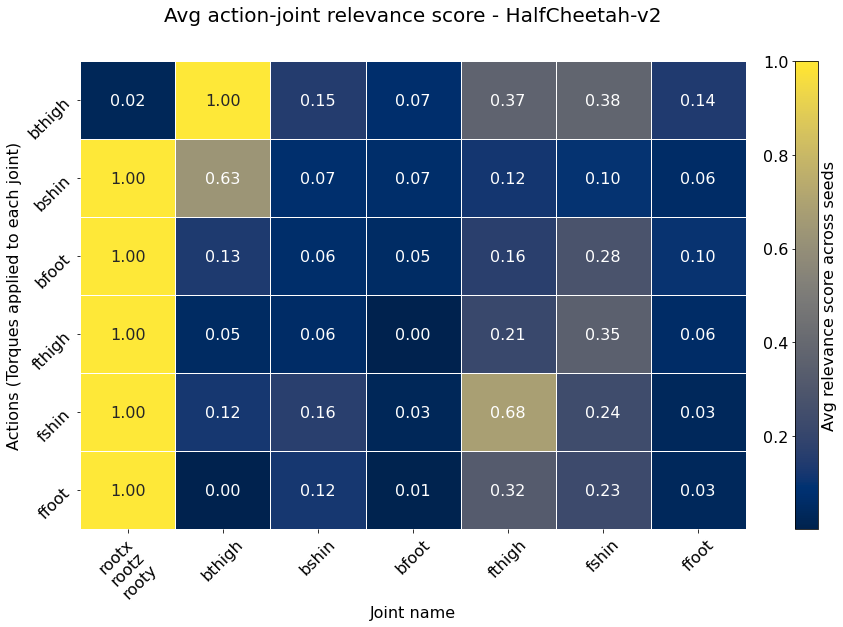

In [8]:
figure_width = 12
figure_height = 9

plot_joint_action_heatmap(np.abs(avg_edge_rel.T),
                          figure_width,
                          figure_height)

## Action Relevance

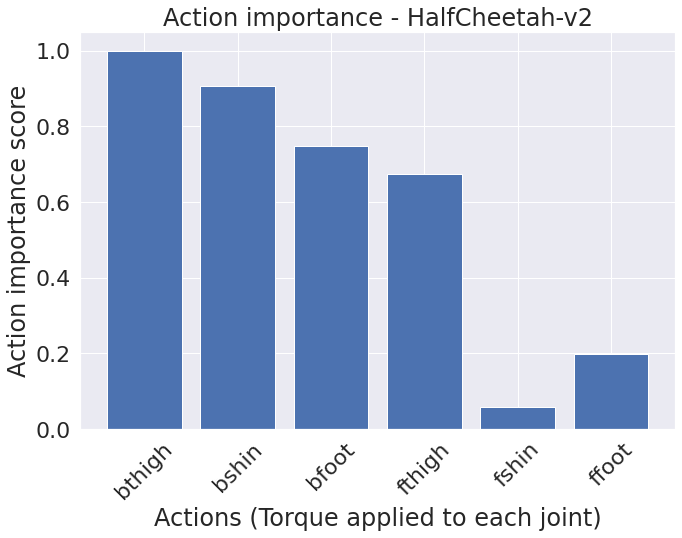

In [9]:
action_rel = np.abs(avg_edge_rel.mean(axis=0)) #half-cheetah, walker-2d
# action_rel = np.abs(edge_relevance.mean(axis=4).mean(axis=3).mean(axis=2).mean(axis=0))
# action_rel = edge_relevance.mean(axis=4).mean(axis=3).mean(axis=2).mean(axis=0)

action_rel /= np.max(action_rel)

sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(10,8))
plt.bar(action_labels, action_rel)
# plt.bar(action_labels, action_rel)
plt.xlabel('Actions (Torque applied to each joint)')
plt.ylabel('Action importance score')
plt.xticks(rotation=45)
plt.title(f'Action importance - {env_name}')
plt.tight_layout()
plt.savefig(os.path.join(exp_path, 'action_importance.jpg'), dpi=300)
sns.reset_orig()
plt.show()

## Joint Relevance

The relevance of action to each joint should be multiplied by the weight of that action to be true

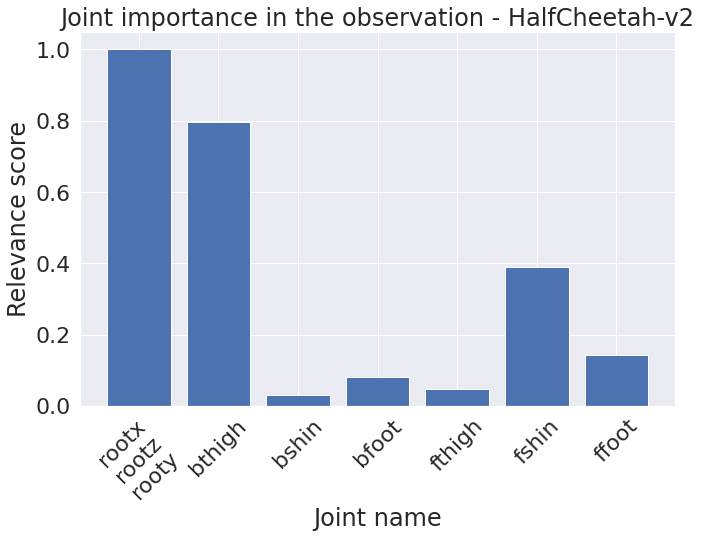

In [10]:
# --------------- First method for calculating importance (without considering action importance)-----------
# walker-2d
# joint_importance = np.abs(avg_edge_rel.mean(axis=1))
# joint_importance /= np.max(joint_importance)

# --------------- Second Method -----------------------------
# joint_importance = np.abs(avg_edge_rel.mean(axis=1))

#---------------- Third Method for calculating joint importance -----------------
# half-cheetah, walker-2d
joint_importance = np.abs(action_rel.dot(avg_edge_rel.T))
joint_importance /= np.max(joint_importance)

sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(10,8))
plt.bar(joint_names, joint_importance)
plt.xlabel('Joint name')
plt.ylabel('Relevance score')
plt.xticks(rotation=45)
plt.title(f'Joint importance in the observation - {env_name}')
plt.tight_layout()
plt.savefig(os.path.join(exp_path, 'joint_importance.jpg'), dpi=300)
sns.reset_orig()
plt.show()